In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df=pd.read_csv('../data/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [4]:
tes=len(df)-18

In [5]:
train=df.iloc[:tes]
test=df.iloc[tes:]

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler=MinMaxScaler()

In [8]:
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
length=12
batch_size=1

In [11]:
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)
valid_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch_size)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [13]:
n_features=1

In [14]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=[length,n_features]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
early=EarlyStopping(monitor='val_loss',mode='min',patience=4)

In [17]:
model.fit(generator,validation_data=(valid_generator),epochs=20,callbacks=[early])

Epoch 1/20


2023-04-14 10:49:19.608082: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


304/304 [==============================] - 37s 121ms/step - loss: 0.0224 - val_loss: 0.0109
Epoch 2/20
304/304 [==============================] - 37s 121ms/step - loss: 0.0164 - val_loss: 0.0016
Epoch 3/20
304/304 [==============================] - 37s 120ms/step - loss: 0.0077 - val_loss: 7.7527e-04
Epoch 4/20
304/304 [==============================] - 85s 279ms/step - loss: 0.0061 - val_loss: 0.0330
Epoch 5/20
304/304 [==============================] - 37s 121ms/step - loss: 0.0032 - val_loss: 9.6933e-04
Epoch 6/20
304/304 [==============================] - 37s 121ms/step - loss: 0.0022 - val_loss: 4.5225e-04
Epoch 7/20
304/304 [==============================] - 37s 121ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/20
304/304 [==============================] - 49s 163ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 9/20
304/304 [==============================] - 37s 123ms/step - loss: 0.0014 - val_loss: 9.1187e-04
Epoch 10/20
304/304 [==============================] - 37s 121ms/ste

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [19]:
loss=pd.DataFrame(model.history.history)

<Axes: >

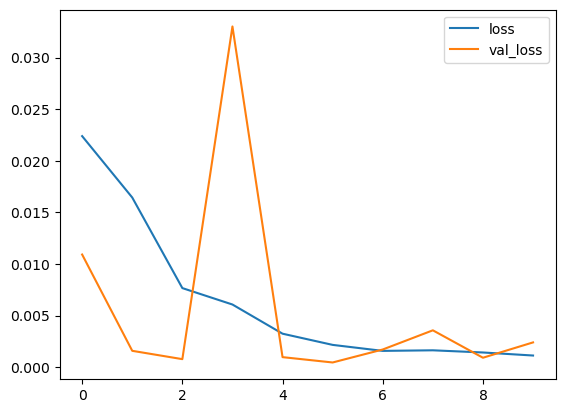

In [20]:
loss.plot()

In [23]:
test_predictions=[]
first=scaled_train[-length:]
current_batch=first.reshape(1,length,n_features)
for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [27]:
test_pred=scaler.inverse_transform(test_predictions)

In [28]:
test['test_pred']=np.round(test_pred,0).astype('int32')

/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_96111/1468589509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test_pred']=np.round(test_pred,0).astype('int32')


<Axes: xlabel='DATE'>

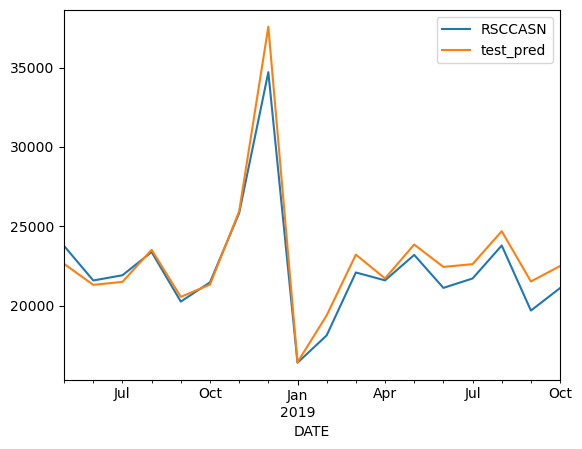

In [30]:
test.plot()

In [31]:
scaled_df=scaler.fit_transform(df)

In [32]:
generator=TimeseriesGenerator(scaled_df,scaled_df,length=length,batch_size=batch_size)

In [33]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=[length,n_features]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [34]:
model.fit(generator,epochs=5)

Epoch 1/5
322/322 [==============================] - 40s 122ms/step - loss: 0.0238
Epoch 2/5
322/322 [==============================] - 39s 120ms/step - loss: 0.0135
Epoch 3/5
322/322 [==============================] - 39s 122ms/step - loss: 0.0103
Epoch 4/5
322/322 [==============================] - 39s 121ms/step - loss: 0.0048
Epoch 5/5
322/322 [==============================] - 39s 121ms/step - loss: 0.0031


In [35]:
forecast=[]
first=scaled_df[-length:]
current_batch=first.reshape(1,length,n_features)
for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [36]:
forecast=scaler.inverse_transform(forecast)

In [37]:
from datetime import datetime

In [39]:
forecast_index=pd.date_range('2019-11-01',periods=18,freq='MS')

In [40]:
forecast_df=pd.DataFrame(index=forecast_index,data=forecast)

<Axes: xlabel='DATE'>

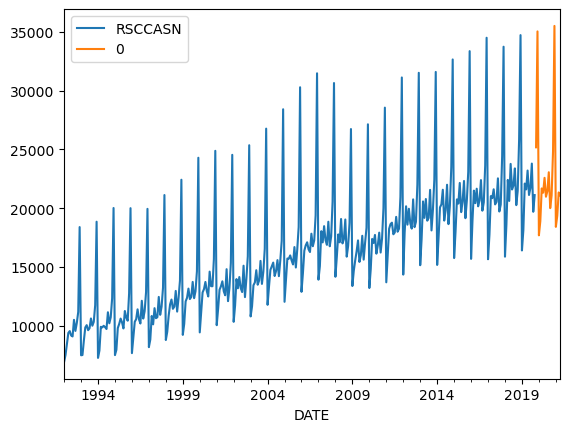

In [43]:
ax=df.plot()
forecast_df.plot(ax=ax)